Build a regression model.

In [291]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [31]:
# The data collected from joining_data.
with open('bike_yelp_fs_outdoor_db.csv') as x:
    ncols = len(x.readline().split(','))
bike_yelp_fs_db = pd.read_csv('bike_yelp_fs_outdoor_db.csv', usecols=range(1,ncols))
bike_yelp_fs_db

,citybike_index,empty_slots,free_bikes,review_count,rating,category_name,distance
0,0,3,16,10.0,4.0,Park,379.0
1,0,3,16,10.0,4.0,Sports and Recreation,379.0
2,0,3,16,10.0,4.0,Park,791.0
3,0,3,16,10.0,4.0,Beach,941.0
4,0,3,16,10.0,4.0,Park,845.0
...,...,...,...,...,...,...,...
46362,673,19,0,NaN,NaN,Dog Park,372.0
46363,673,19,0,NaN,NaN,Bathing Area,866.0
46364,673,19,0,NaN,NaN,Farm,88.0
46365,673,19,0,NaN,NaN,Hiking Trail,687.0


In [27]:
# Right now there are too many duplicate data points
bike_yelp_fs_db[['empty_slots',	'free_bikes', 'review_count', 'rating',	'distance']].describe()

,empty_slots,free_bikes,review_count,rating,distance
count,46367.000000,46367.00000,44286.000000,44286.000000,46366.000000
mean,8.899303,9.67410,21.736192,3.758513,580.508821
std,6.509382,6.63962,94.476266,0.850787,357.829003
min,0.000000,0.00000,1.000000,1.000000,6.000000
25%,4.000000,4.00000,1.000000,3.000000,370.000000
50%,8.000000,9.00000,4.000000,4.000000,563.000000
75%,13.000000,14.00000,11.000000,4.500000,780.000000
max,38.000000,36.00000,869.000000,5.000000,5339.000000


In [28]:
# The missing data and null values
total = bike_yelp_fs_db.isnull().sum().sort_values(ascending=False)
percent = (bike_yelp_fs_db.isnull().sum()/bike_yelp_fs_db.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
review_count,2081,0.044881
rating,2081,0.044881
category_name,1,0.000022
distance,1,0.000022
citybike_index,0,0.000000
empty_slots,0,0.000000
free_bikes,0,0.000000


In [121]:
bike_fs_df = bike_yelp_fs_db[['citybike_index', 'empty_slots', 'free_bikes', 'category_name', 'distance']]
bike_fs_df = bike_fs_df.dropna()
bike_fs_df[bike_fs_df['distance'].isna()]
bike_fs_df = bike_fs_df.drop_duplicates()

In [122]:
print( bike_fs_df[['citybike_index', 'empty_slots', 'free_bikes']].drop_duplicates().reset_index(drop=True) )

     citybike_index  empty_slots  free_bikes
0                 0            3          16
1                 1           13           2
2                 2            9          14
3                 3            9          15
4                 4            9          18
..              ...          ...         ...
668             669           11           3
669             670           18           1
670             671           13           1
671             672           15           0
672             673           19           0

[673 rows x 3 columns]


In [116]:
number_of_stations_near_cat = bike_fs_df.groupby('category_name').citybike_index.count()
print(number_of_stations_near_cat.sort_values(ascending=False).head(20))

category_name
Park                           2671
Playground                      810
Sports and Recreation           508
Monument                        411
Dog Park                        320
Garden                          261
Landmarks and Outdoors          257
Plaza                           225
Other Great Outdoors            177
Hiking Trail                    172
Urban Park                      163
Scenic Lookout                  134
Beach                           118
Historic and Protected Site      92
Rock Climbing Spot               81
Structure                        81
Campground                       71
Bridge                           70
Lake                             66
Harbor or Marina                 62
Name: citybike_index, dtype: int64


In [117]:
bike_fs_df[bike_fs_df.category_name == 'Park'].distance

0         379.0
2         791.0
4         845.0
12        173.0
120       505.0
          ...  
46350    1039.0
46352     932.0
46354     513.0
46355     676.0
46357     965.0
Name: distance, Length: 2671, dtype: float64

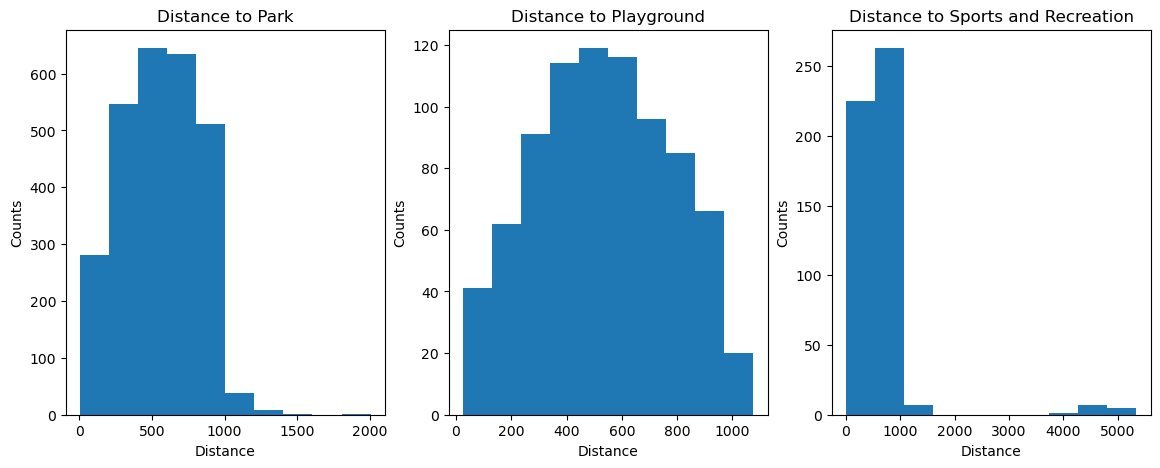

In [118]:
# Check the data to find outliers and to see if the data is normalized.
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Distance to Park histogram
axes[0].hist(bike_fs_df[bike_fs_df.category_name == 'Park'].distance)
# Customize other aspects of the plot
axes[0].set_title('Distance to Park')
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('Counts')

# Distance to Playground histogram
axes[1].hist(bike_fs_df[bike_fs_df.category_name == 'Playground'].distance)
axes[1].set_title('Distance to Playground')
axes[1].set_xlabel('Distance')
axes[1].set_ylabel('Counts')

# Distance to Sports and Recreation histogram
axes[2].hist(bike_fs_df[bike_fs_df.category_name == 'Sports and Recreation'].distance)
axes[2].set_title('Distance to Sports and Recreation')
axes[2].set_xlabel('Distance')
axes[2].set_ylabel('Counts')

plt.show()

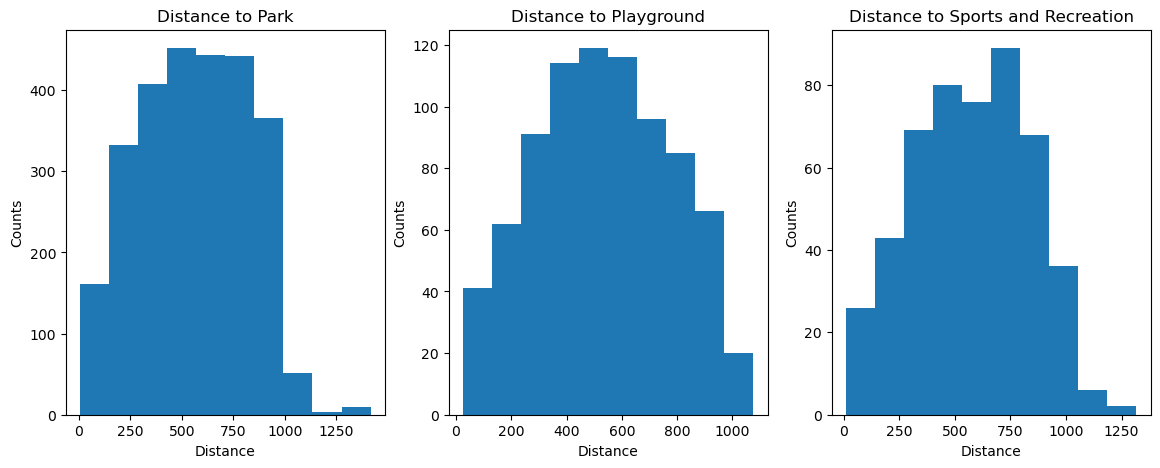

In [119]:
# Remove the outliers and put the data into new df, bike_fs_df_w_top3cat
# The data is more normailzed now.

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Distance to Park histogram
axes[0].hist(bike_fs_df[(bike_fs_df.category_name == 'Park') & (bike_fs_df.distance <= 1500)].distance)
# Customize other aspects of the plot
axes[0].set_title('Distance to Park')
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('Counts')

# Distance to Playground histogram
axes[1].hist(bike_fs_df[bike_fs_df.category_name == 'Playground'].distance)
axes[1].set_title('Distance to Playground')
axes[1].set_xlabel('Distance')
axes[1].set_ylabel('Counts')

# Distance to Sports and Recreation histogram
axes[2].hist(bike_fs_df[(bike_fs_df.category_name == 'Sports and Recreation') & (bike_fs_df.distance <= 2000)].distance)
axes[2].set_title('Distance to Sports and Recreation')
axes[2].set_xlabel('Distance')
axes[2].set_ylabel('Counts')

plt.show()

In [124]:
# Remove the outliers
index_park_dist = bike_fs_df[(bike_fs_df.category_name == 'Park') & (bike_fs_df.distance > 1500)].index
bike_fs_df.drop(index_park_dist, inplace=True)
index_park_dist = bike_fs_df[(bike_fs_df.category_name == 'Sports and Recreation') & (bike_fs_df.distance > 2000)].index
bike_fs_df.drop(index_park_dist, inplace=True)
bike_fs_df

,citybike_index,empty_slots,free_bikes,category_name,distance
0,0,3,16,Park,379.0
1,0,3,16,Sports and Recreation,379.0
2,0,3,16,Park,791.0
3,0,3,16,Beach,941.0
4,0,3,16,Park,845.0
...,...,...,...,...,...
46362,673,19,0,Dog Park,372.0
46363,673,19,0,Bathing Area,866.0
46364,673,19,0,Farm,88.0
46365,673,19,0,Hiking Trail,687.0


In [125]:
# Make a new df with the top 3 categories
bike_fs_df_w_top3cat = bike_fs_df[['citybike_index', 'empty_slots', 'free_bikes']].drop_duplicates().reset_index(drop=True)
bike_fs_df_w_top3cat['num_parks'] = bike_fs_df[bike_fs_df.category_name == 'Park'].groupby('citybike_index')['category_name'].count()
bike_fs_df_w_top3cat['ave_dis_park'] = bike_fs_df[bike_fs_df.category_name == 'Park'].groupby('citybike_index')['distance'].mean()
bike_fs_df_w_top3cat['num_plygrd'] = bike_fs_df[bike_fs_df.category_name == 'Playground'].groupby('citybike_index')['category_name'].count()
bike_fs_df_w_top3cat['ave_dis_plygrd'] = bike_fs_df[bike_fs_df.category_name == 'Playground'].groupby('citybike_index')['distance'].mean()
bike_fs_df_w_top3cat['num_sr'] = bike_fs_df[bike_fs_df.category_name == 'Sports and Recreation'].groupby('citybike_index')['category_name'].count()
bike_fs_df_w_top3cat['ave_dis_sr'] = bike_fs_df[bike_fs_df.category_name == 'Sports and Recreation'].groupby('citybike_index')['distance'].mean()
bike_fs_df_w_top3cat[['num_parks', 'num_plygrd', 'num_sr']] = bike_fs_df_w_top3cat[['num_parks', 'num_plygrd', 'num_sr']].fillna(0)

In [275]:
bike_fs_df_w_top3cat

,citybike_index,empty_slots,free_bikes,num_parks,ave_dis_park,num_plygrd,ave_dis_plygrd,num_sr,ave_dis_sr
0,0,3,16,4.0,547.00,2.0,150.500000,1.0,379.000000
1,1,13,2,4.0,479.75,1.0,61.000000,0.0,NaN
2,2,9,14,4.0,590.75,2.0,303.000000,1.0,257.000000
3,3,9,15,2.0,457.00,0.0,NaN,1.0,472.000000
4,4,9,18,2.0,753.50,1.0,749.000000,0.0,NaN
...,...,...,...,...,...,...,...,...,...
668,669,11,3,5.0,512.80,3.0,548.000000,1.0,733.000000
669,670,18,1,4.0,637.00,0.0,NaN,1.0,796.000000
670,671,13,1,5.0,658.00,3.0,967.333333,1.0,888.000000
671,672,15,0,4.0,617.75,4.0,484.000000,1.0,779.000000


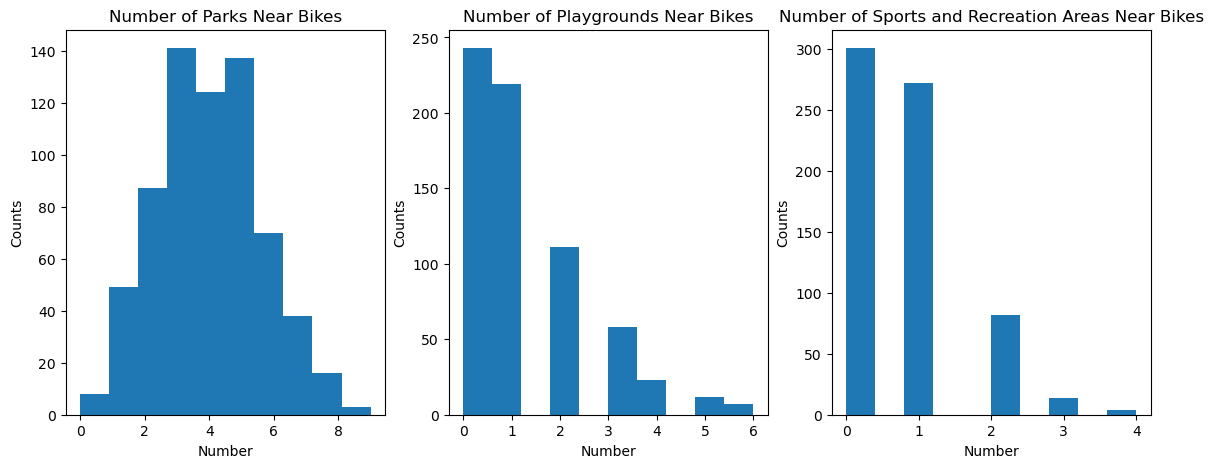

In [273]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Distance to Park histogram
axes[0].hist(bike_fs_df_w_top3cat.num_parks)
# Customize other aspects of the plot
axes[0].set_title('Number of Parks Near Bikes')
axes[0].set_xlabel('Number')
axes[0].set_ylabel('Counts')

# Distance to Playground histogram
axes[1].hist(bike_fs_df_w_top3cat.num_plygrd)
axes[1].set_title('Number of Playgrounds Near Bikes')
axes[1].set_xlabel('Number')
axes[1].set_ylabel('Counts')

# Distance to Sports and Recreation histogram
axes[2].hist(bike_fs_df_w_top3cat.num_sr)
axes[2].set_title('Number of Sports and Recreation Areas Near Bikes')
axes[2].set_xlabel('Number')
axes[2].set_ylabel('Counts')

plt.show()

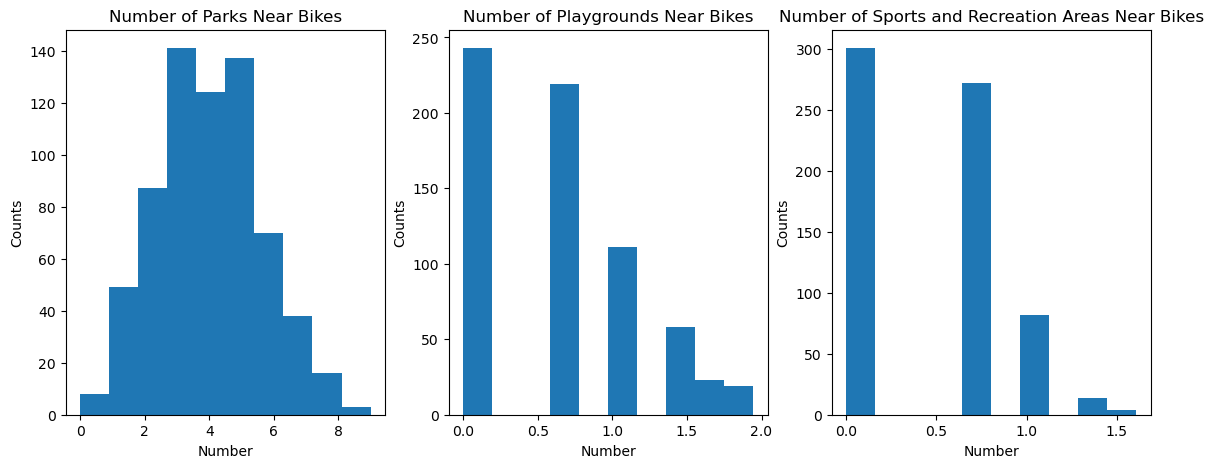

In [320]:
# As the plots shows, the high amount of zeros makes it difficult to normalize the variables.
# The distributions are more normalized after applying the natural logarithm,
# even compared to (np.log(values_range.max() - datapoint + 1))

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Distance to Park histogram
axes[0].hist(bike_fs_df_w_top3cat.num_parks)
# Customize other aspects of the plot
axes[0].set_title('Number of Parks Near Bikes')
axes[0].set_xlabel('Number')
axes[0].set_ylabel('Counts')

# Distance to Playground histogram
axes[1].hist(np.log(bike_fs_df_w_top3cat.num_plygrd + 1))
axes[1].set_title('Number of Playgrounds Near Bikes')
axes[1].set_xlabel('Number')
axes[1].set_ylabel('Counts')

# Distance to Sports and Recreation histogram
axes[2].hist(np.log(bike_fs_df_w_top3cat.num_sr + 1))
axes[2].set_title('Number of Sports and Recreation Areas Near Bikes')
axes[2].set_xlabel('Number')
axes[2].set_ylabel('Counts')

plt.show()

<AxesSubplot:xlabel='free_bikes', ylabel='Count'>

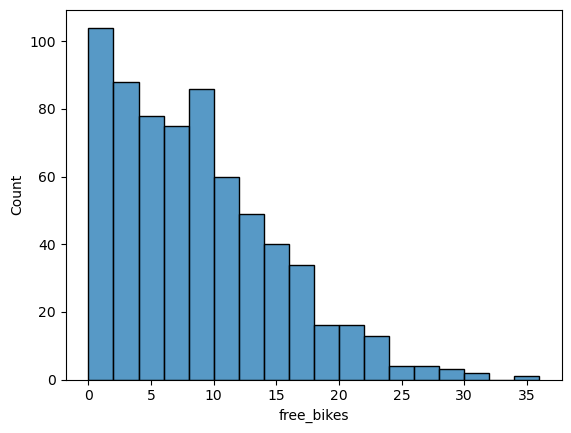

In [289]:
sns.histplot(bike_fs_df_w_top3cat.free_bikes)

1.1055996143965771e-16


<AxesSubplot:xlabel='free_bikes', ylabel='Count'>

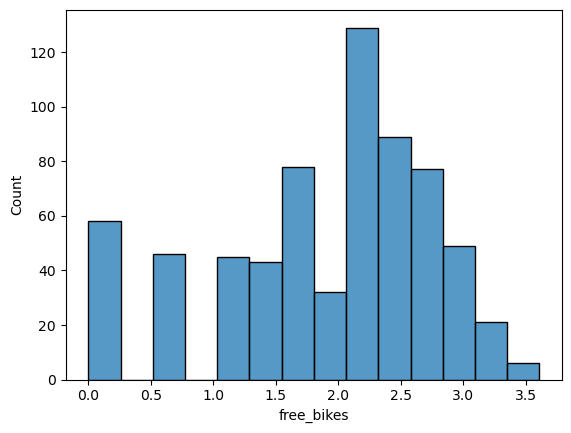

In [293]:
# The normalized values for bikes passes the Shapiro-Wilk test.
log_left_skew = np.log(bike_fs_df_w_top3cat.free_bikes + 1) # +1 to avoid log of zero
stat, p = stats.shapiro(log_left_skew)
print(p) # p < 0.05 and the null hypothesis that this is a normal distribution is rejected
sns.histplot(log_left_skew)

In [148]:
bike_yelp_df = bike_yelp_fs_db[['citybike_index', 'review_count', 'rating']]
bike_yelp_df = bike_yelp_df.drop_duplicates()
# bike_yelp_df = bike_yelp_df.dropna(axis=0)
bike_yelp_df[bike_yelp_df.citybike_index > 1].head(20)

,citybike_index,review_count,rating
160,2,10.0,4.0
175,2,11.0,3.0
190,2,1.0,5.0
205,2,26.0,4.5
220,2,30.0,3.5
235,2,3.0,3.0
250,2,1.0,2.0
265,2,2.0,3.5
280,3,11.0,4.0
293,3,112.0,4.5


In [216]:
# This dataframe, 'bike_yelp_rat_sum_df', groups by the citybike_index to count the number of reviews for each rating.
df2 = bike_yelp_df[bike_yelp_df['review_count'].notnull()]
bike_yelp_rat_sum_df = df2.groupby(['citybike_index', 'rating']).review_count.sum().reset_index()
bike_yelp_rat_sum_df

,citybike_index,rating,review_count
0,0,2.0,1.0
1,0,3.0,14.0
2,0,3.5,32.0
3,0,4.0,10.0
4,0,4.5,26.0
...,...,...,...
2010,490,4.5,95.0
2011,490,5.0,9.0
2012,491,4.5,11.0
2013,491,5.0,1.0


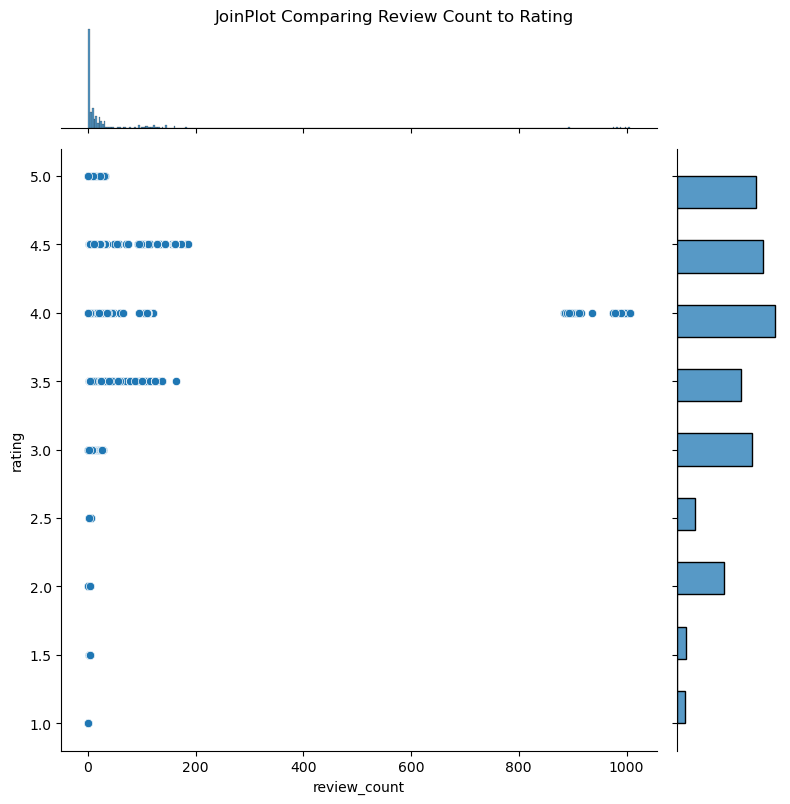

In [179]:
# The x-axis plot shows that there is a high skew of no ratings given and some locations have very high outliers.
# The y-axis plot shows that the reviews are more skewed towards the 5 star ratings.
sns.jointplot(data=bike_yelp_rat_sum_df, 
              x="review_count", 
              y="rating",
              height = 8    # a jointplot is a square by default 
            )
plt.suptitle("JoinPlot Comparing Review Count to Rating", y=1)

plt.show()

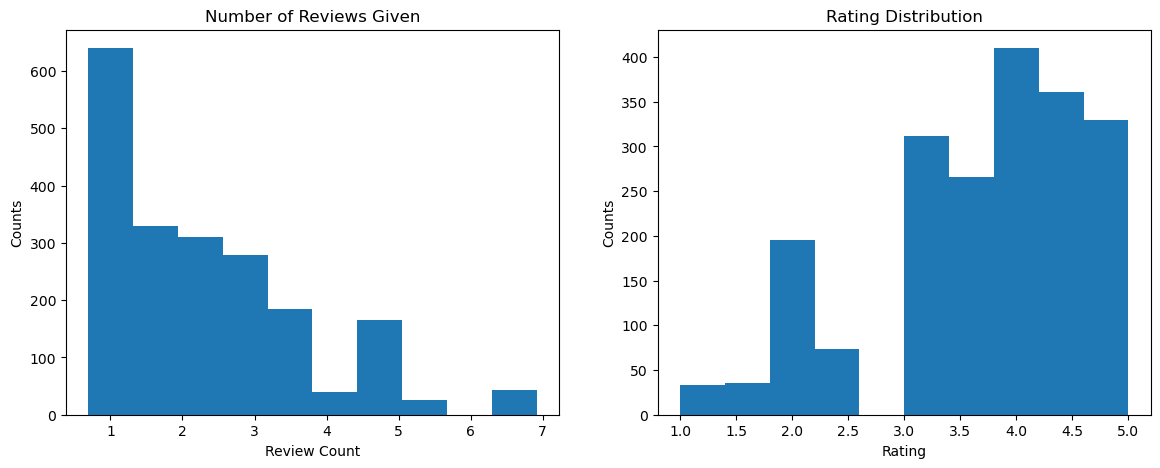

In [295]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# The number of reviews histogram looks more normalized with a natural logarithm applied.
axes[0].hist(np.log(bike_yelp_rat_sum_df.review_count + 1))
# Customize other aspects of the plot
axes[0].set_title('Number of Reviews Given')
axes[0].set_xlabel('Review Count')
axes[0].set_ylabel('Counts')

# Distance to Park histogram
axes[1].hist(bike_yelp_rat_sum_df.rating)
axes[1].set_title('Rating Distribution')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Counts')

plt.show()

In [248]:
# Make a new dataframe to get the median for each citybike_index.
# Because the distributions were skewed, the median is recorded for each citybike_index instead of the mode.
bike_yelp_df_w_median_rr = pd.DataFrame()
bike_yelp_df_w_median_rr['med_rating'] = bike_yelp_rat_sum_df.groupby('citybike_index')['rating'].median()
bike_yelp_df_w_median_rr['med_review'] = bike_yelp_rat_sum_df.groupby('citybike_index')['review_count'].median()
bike_yelp_df_w_median_rr = bike_yelp_df_w_median_rr.reset_index()
bike_yelp_df_w_median_rr

,citybike_index,med_rating,med_review
0,0,3.75,12.0
1,1,3.50,7.0
2,2,3.75,12.0
3,3,3.75,57.5
4,4,3.50,5.0
...,...,...,...
476,488,4.25,2.5
477,489,3.50,2.5
478,490,4.25,14.5
479,491,4.75,6.0


In [243]:
# There are no nan values.
bike_yelp_df_w_median_rr_nan = bike_yelp_df_w_median_rr[bike_yelp_df_w_median_rr.med_rating.isna()]
bike_yelp_df_w_median_rr_nan

,med_rating,med_review
citybike_index,,


In [321]:
# NOW MERGE!!!
left = bike_fs_df_w_top3cat
right = bike_yelp_df_w_median_rr
reg_an_df = pd.merge(left, right, 'outer', on='citybike_index')
reg_an_df.drop(reg_an_df[reg_an_df.empty_slots.isna()].index.values, inplace=True)
reg_an_df.iloc[reg_an_df[reg_an_df.empty_slots.isna()].index.values] # Remove the null row with no information

,citybike_index,empty_slots,free_bikes,num_parks,ave_dis_park,num_plygrd,ave_dis_plygrd,num_sr,ave_dis_sr,med_rating,med_review


In [322]:
reg_an_df2 = reg_an_df

In [323]:
# Apply lambda functions to normalize the free_bikes and review_count columns
reg_an_df2['free_bikes'] = reg_an_df2['free_bikes'].apply(lambda x: np.log(x + 1))
reg_an_df2['med_review'] = reg_an_df2['med_review'].apply(lambda x: np.log(x + 1))
reg_an_df2['num_plygrd'] = reg_an_df2['num_plygrd'].apply(lambda x: np.log(x + 1))
reg_an_df2['num_sr'] = reg_an_df2['num_sr'].apply(lambda x: np.log(x + 1))
reg_an_df2

,citybike_index,empty_slots,free_bikes,num_parks,ave_dis_park,num_plygrd,ave_dis_plygrd,num_sr,ave_dis_sr,med_rating,med_review
0,0,3.0,2.833213,4.0,547.00,1.098612,150.500000,0.693147,379.000000,3.75,2.564949
1,1,13.0,1.098612,4.0,479.75,0.693147,61.000000,0.000000,NaN,3.50,2.079442
2,2,9.0,2.708050,4.0,590.75,1.098612,303.000000,0.693147,257.000000,3.75,2.564949
3,3,9.0,2.772589,2.0,457.00,0.000000,NaN,0.693147,472.000000,3.75,4.069027
4,4,9.0,2.944439,2.0,753.50,0.693147,749.000000,0.000000,NaN,3.50,1.791759
...,...,...,...,...,...,...,...,...,...,...,...
668,669,11.0,1.386294,5.0,512.80,1.386294,548.000000,0.693147,733.000000,NaN,NaN
669,670,18.0,0.693147,4.0,637.00,0.000000,NaN,0.693147,796.000000,NaN,NaN
670,671,13.0,0.693147,5.0,658.00,1.386294,967.333333,0.693147,888.000000,NaN,NaN
671,672,15.0,0.000000,4.0,617.75,1.609438,484.000000,0.693147,779.000000,NaN,NaN


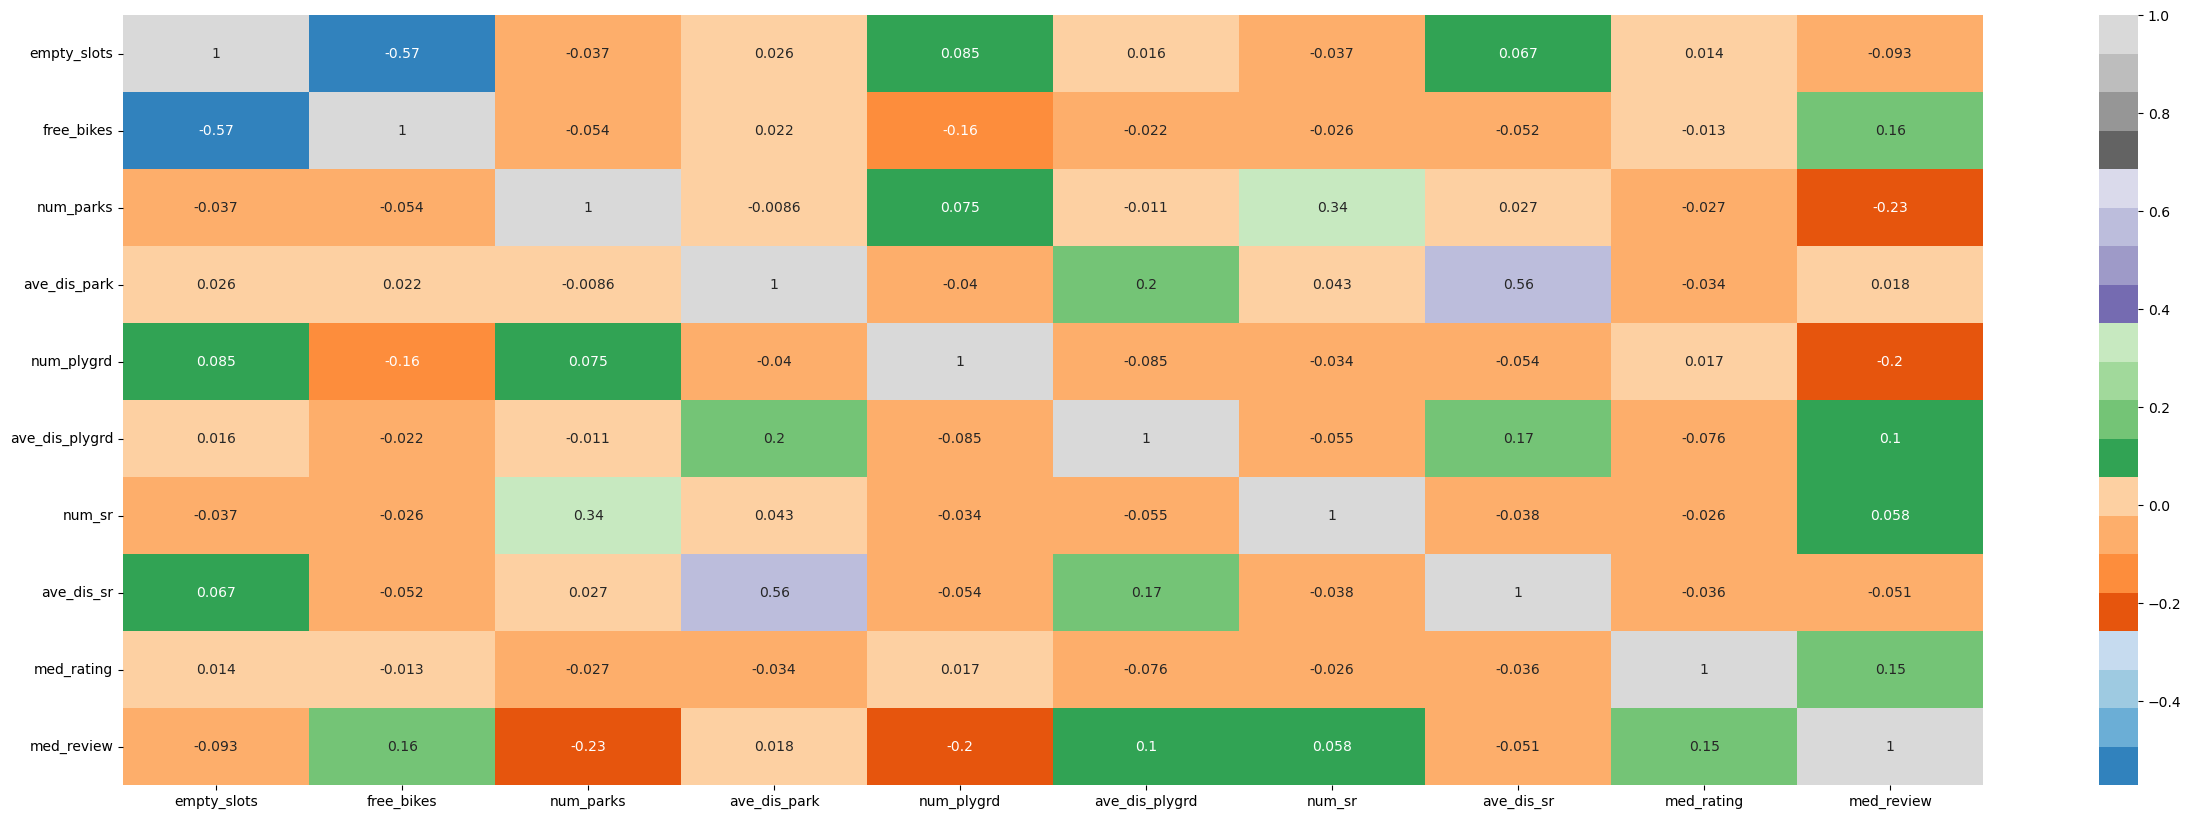

In [419]:
# This is a correlation of all the variables in the Regression Analysis DataFrame.
# Testing for multicollinearity.
plt.figure(figsize = (30,10))
sns.heatmap(reg_an_df2.iloc[:, 1:].corr(), annot = True, cmap="tab20c")
plt.show()

In [326]:
reg_an_df2.iloc[:, 1:].describe()

,empty_slots,free_bikes,num_parks,ave_dis_park,num_plygrd,ave_dis_plygrd,num_sr,ave_dis_sr,med_rating,med_review
count,673.000000,673.000000,673.000000,665.000000,673.000000,430.000000,673.000000,372.000000,480.000000,480.000000
mean,9.863299,1.907075,3.964339,560.849797,0.633417,546.581628,0.452404,579.993504,3.798437,2.022834
std,6.277727,0.883222,1.787500,151.743693,0.552650,218.252299,0.438438,238.816332,0.586133,0.863098
min,0.000000,0.000000,0.000000,88.000000,0.000000,34.000000,0.000000,11.000000,1.000000,0.693147
25%,5.000000,1.386294,3.000000,460.750000,0.000000,402.250000,0.000000,409.750000,3.500000,1.386294
50%,9.000000,2.079442,4.000000,565.400000,0.693147,532.575000,0.693147,574.750000,4.000000,1.908856
75%,14.000000,2.564949,5.000000,664.500000,1.098612,701.750000,0.693147,759.125000,4.250000,2.639057
max,38.000000,3.610918,9.000000,1032.666667,1.945910,1076.000000,1.609438,1317.000000,5.000000,4.672829


In [327]:
reg_an_df2.to_csv('fitted_data_for_lr.csv')

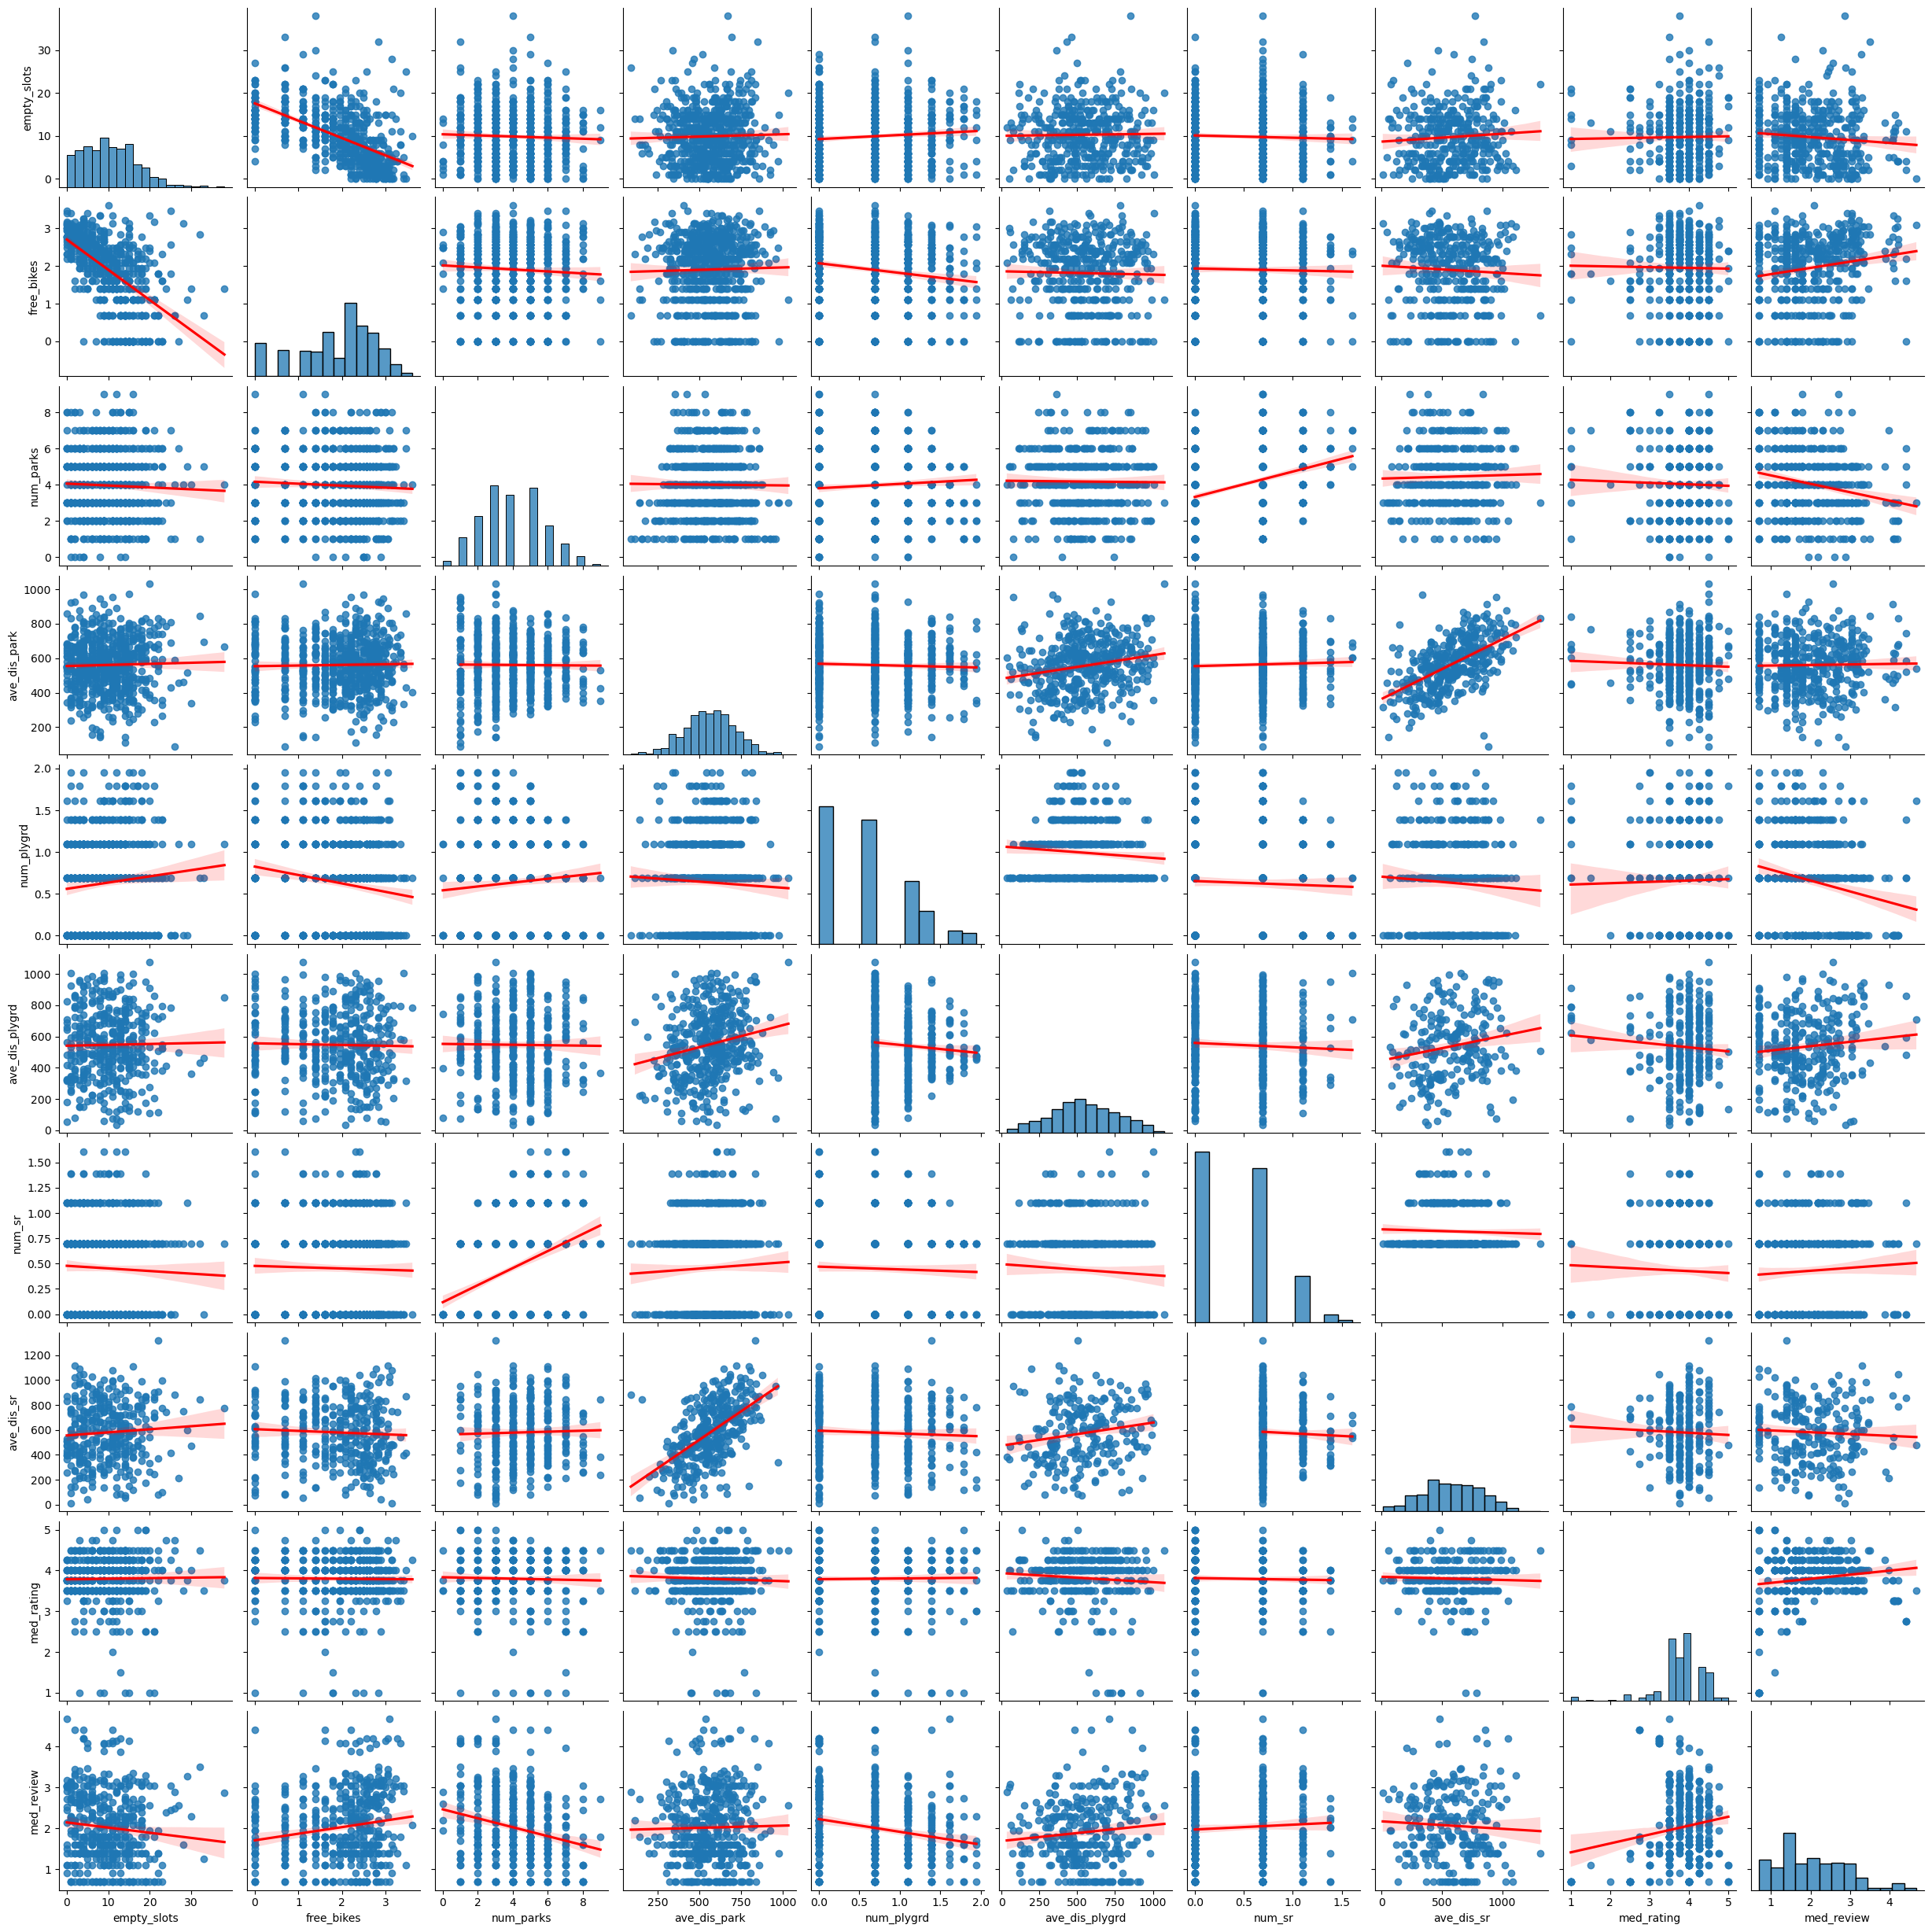

In [333]:
# Check for 
sns.pairplot(reg_an_df2.iloc[:, 1:], kind="reg", plot_kws={'line_kws':{'color':'red'}})

In [338]:
import statsmodels.api as sm

In [349]:
# Set the values
X = pd.DataFrame(reg_an_df2[['empty_slots',	'num_parks', 'ave_dis_park', 'num_plygrd', 'ave_dis_plygrd', 'num_sr', 'ave_dis_sr', 'med_rating', 'med_review']],
                 columns = reg_an_df2[['empty_slots',	'num_parks', 'ave_dis_park', 'num_plygrd', 'ave_dis_plygrd', 'num_sr', 'ave_dis_sr', 'med_rating', 'med_review']].columns.values)

y = pd.Series(reg_an_df2['free_bikes'], name='free_bikes')


In [341]:
X = sm.add_constant(X) # adding a constant
model = sm.OLS(y, X, missing = 'drop')
results = model.fit() # fit the model (this is where OLS is actually being run)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             free_bikes   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     9.152
Date:                Sun, 30 Jul 2023   Prob (F-statistic):           4.72e-11
Time:                        01:06:37   Log-Likelihood:                -181.24
No. Observations:                 165   AIC:                             382.5
Df Residuals:                     155   BIC:                             413.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.4206      0.661      5.

Provide model output and an interpretation of the results. 

In [417]:
# Set the values
X_3 = pd.DataFrame(reg_an_df2[['empty_slots', 'num_parks','num_plygrd']], 
                   columns = reg_an_df2[['empty_slots', 'num_parks','num_plygrd']].columns.values)

y_3 = pd.Series(reg_an_df2['free_bikes'], name='free_bikes')

In [418]:
X_3 = sm.add_constant(X_3) # adding a constant
model = sm.OLS(y_3, X_3, missing = 'drop')
results = model.fit() # fit the model (this is where OLS is actually being run)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             free_bikes   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     116.3
Date:                Sun, 30 Jul 2023   Prob (F-statistic):           1.24e-60
Time:                        02:34:58   Log-Likelihood:                -729.60
No. Observations:                 673   AIC:                             1467.
Df Residuals:                     669   BIC:                             1485.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.9297      0.085     34.590      

In [431]:
# Set the values
X_4 = pd.DataFrame(reg_an_df2[['empty_slots','num_plygrd', 'med_review']], 
                   columns = reg_an_df2[['empty_slots', 'num_plygrd', 'med_review']].columns.values)

y_4 = pd.Series(reg_an_df2['free_bikes'], name='free_bikes')

In [432]:
X_4 = sm.add_constant(X_4) # adding a constant
model = sm.OLS(y_4, X_4, missing = 'drop')
results = model.fit() # fit the model (this is where OLS is actually being run)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             free_bikes   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     82.95
Date:                Sun, 30 Jul 2023   Prob (F-statistic):           3.47e-43
Time:                        03:16:14   Log-Likelihood:                -516.24
No. Observations:                 480   AIC:                             1040.
Df Residuals:                     476   BIC:                             1057.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.6352      0.113     23.309      

In [ ]:
# Here there are three OLS Regression Results.  The results between the last two are very similar but there are some minor differences.
# The first OLS regression contained all the potential independent variables.  The p-values were all greater than
# zero except for empty_slots.  Those with the highest p-values were discarded one-by-one different combinations were
# attempted until the variable p-values were all below the confidence interval 0.05. 
# Two OLS results have variables with p-values lower than 0.05, and a Prob (F-statistic) approaching zero, so the regression coefficients are not zero.
# A regression model with empty_slots, num_parks, and num_plygrd as variables was selected for three factors:
# - The adjusted R Squared value was greater with 0.34 so more of the dependent variable is explained by changes in the independent variables.
# - The skew was closer to 0, so the data is more symmetric.
# - The Durbin-Watson measurement is closer to 2, so the data has less heteroskedasticity.

# Stretch

How can you turn the regression model into a classification model?

In [433]:
# Right now the highest count of categories is 'Park'.  Instead of looking at the number of bikes
# in the regression model, a new column can be changed into a boolean to determine if a location is a park or not.

number_of_stations_near_cat = bike_fs_df.groupby('category_name').citybike_index.count()
print(number_of_stations_near_cat.sort_values(ascending=False).head(20))

category_name
Park                           2669
Playground                      810
Sports and Recreation           495
Monument                        411
Dog Park                        320
Garden                          261
Landmarks and Outdoors          257
Plaza                           225
Other Great Outdoors            177
Hiking Trail                    172
Urban Park                      163
Scenic Lookout                  134
Beach                           118
Historic and Protected Site      92
Rock Climbing Spot               81
Structure                        81
Campground                       71
Bridge                           70
Lake                             66
Harbor or Marina                 62
Name: citybike_index, dtype: int64


In [434]:
bike_yelp_fs_db

,citybike_index,empty_slots,free_bikes,review_count,rating,category_name,distance
0,0,3,16,10.0,4.0,Park,379.0
1,0,3,16,10.0,4.0,Sports and Recreation,379.0
2,0,3,16,10.0,4.0,Park,791.0
3,0,3,16,10.0,4.0,Beach,941.0
4,0,3,16,10.0,4.0,Park,845.0
...,...,...,...,...,...,...,...
46362,673,19,0,NaN,NaN,Dog Park,372.0
46363,673,19,0,NaN,NaN,Bathing Area,866.0
46364,673,19,0,NaN,NaN,Farm,88.0
46365,673,19,0,NaN,NaN,Hiking Trail,687.0
